In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import pickle
import gzip
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
with gzip.open('model.pz', 'rb') as f:
    pymc_model = pickle.load(f)

In [3]:
with gzip.open('model_data.pz', 'rb') as f:
    data = pickle.load(f)
    ll = data['ll']

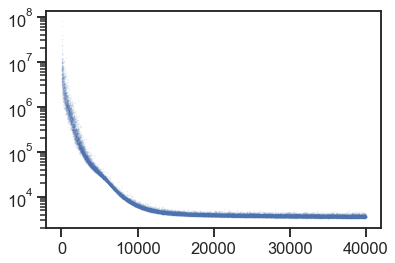

In [5]:
with gzip.open('results_small_xnclip_0.01.pz', 'rb') as f:
    results = pickle.load(f)
    approx = results['approx']    
    hist = results['hist']
    trace = results['trace']

plt.semilogy(hist.hist, '.', ms=1, alpha=.1)

# with gzip.open('results_0.0025.pz', 'rb') as f:
#     results = pickle.load(f)
#     approx = results['approx']    
#     hist5 = results['hist']

# plt.semilogy(hist5.hist, '.', ms=1, alpha=.1)

# plt.ylim([2E5, 4E5])

# plt.ylim([2E5, 4E5])

In [6]:
data['vn'].columns = ['biomass', 'glucose', 'fructose', 'gluconate', '2-ketogluconate', 'muconate']

Text(0.5, 0, 'Measured')

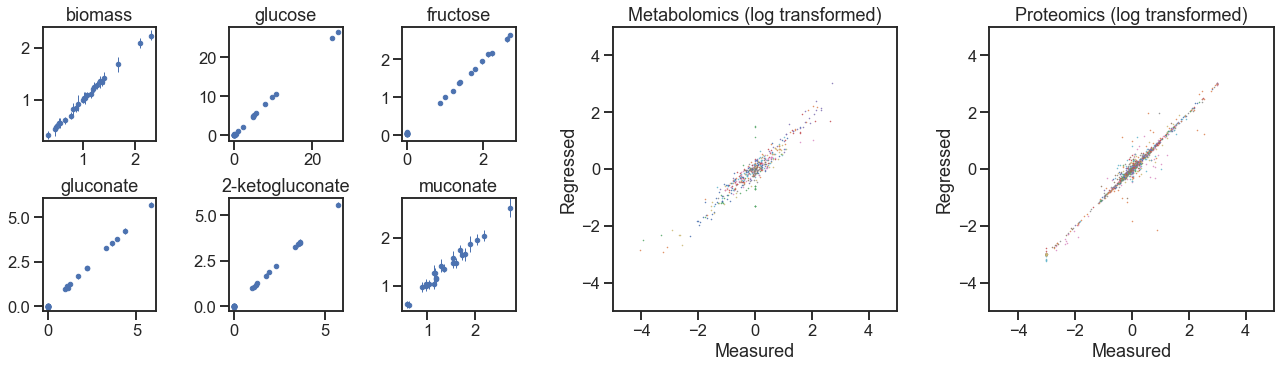

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(18, 5))
gs = fig.add_gridspec(2, 7)

ax_fluxes = [fig.add_subplot(gs[i, j], aspect='equal') for i in range(2) for j in range(3)]
vn_model = results['trace']['vn_ss'][:, :, data['v_inds']]

for i, (name, df) in enumerate(data['vn'].iteritems()):
    ax = ax_fluxes[i]
    model_mean = vn_model[:, :, i].mean(0)
    model_hpd = pm.hpd(vn_model[:, :, i])

    ax.errorbar(df, model_mean, yerr=np.abs(model_hpd - model_mean[:, np.newaxis]).T,
                marker='.', ls='', label=name, elinewidth=1)
    
    ax.set_ylim(ax.get_xlim())
    
    ax.set_title(name)
    
ax_xn = fig.add_subplot(gs[:, 3:5], aspect='equal')
ax_xn.plot(data['xn'], results['trace']['chi_ss'][:, :, data['x_inds']].mean(0), '.', ms=1)
ax_xn.set_xlim([-5, 5])
ax_xn.set_ylim([-5, 5])
ax_xn.set_title('Metabolomics (log transformed)')
ax_xn.set_ylabel('Regressed')
ax_xn.set_xlabel('Measured')

ax_en = fig.add_subplot(gs[:, 5:], aspect='equal')
ax_en.plot(data['en'], results['trace']['log_en_t'][:, :, data['e_inds']].mean(0), '.', ms=1, rasterized=True)
ax_en.set_xlim([-5, 5])
ax_en.set_ylim([-5, 5])
ax_en.set_title('Proteomics (log transformed)')
ax_en.set_ylabel('Regressed')
ax_en.set_xlabel('Measured')

# plt.savefig('20200324_regression_figures.svg')

In [12]:
with pymc_model:
    trace_prior = pm.sample_prior_predictive(samples=50)

100%|██████████| 50/50 [00:03<00:00, 14.26it/s]


Text(0, 0.5, 'FCC (muconate flux)')

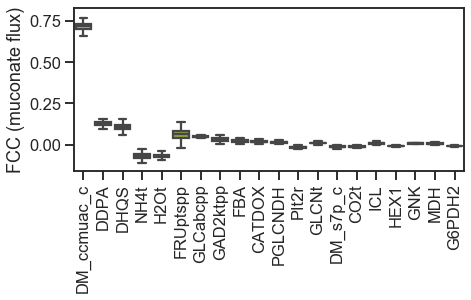

In [16]:
fcc = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=ex)[data['r_labels'].index('DM_ccmuac_c')]
                             for ex in tqdm(trace['Ex'])]), columns=data['r_labels'])

fcc_prior = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=ex)[data['r_labels'].index('DM_ccmuac_c')]
                                   for ex in tqdm(trace_prior['Ex'])]), columns=data['r_labels'])

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hpd = pm.hpd(fcc.values)
fcc_consistent = np.sign(hpd[:, 0]) == np.sign(hpd[:, 1])

plt.figure(figsize=(7,3))
sns.boxplot(x='variable', y='value', data=fcc.loc[:, fcc_consistent].melt(),
            order=fcc.loc[:, fcc_consistent].median().abs().sort_values(ascending=False).index[:20], 
            fliersize=0)

plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('FCC (muconate flux)')

# plt.savefig('fcc_muconate.svg')

100%|██████████| 50/50 [00:06<00:00,  7.70it/s]


Text(0, 0.5, 'FCC (Growth rate)')

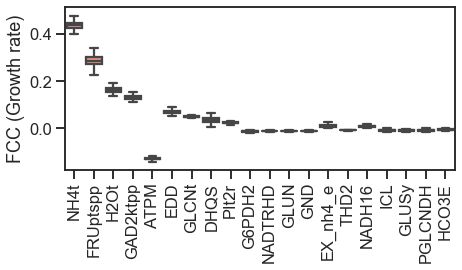

In [17]:
fcc = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=ex)[data['r_labels'].index('Biomass_Ecoli_core_w_GAM')]
                             for ex in tqdm(trace['Ex'])]), columns=data['r_labels'])

fcc_prior = pd.DataFrame(np.array([ll.flux_control_coefficient(Ex=ex)[data['r_labels'].index('Biomass_Ecoli_core_w_GAM')]
                                   for ex in tqdm(trace_prior['Ex'])]), columns=data['r_labels'])

# Calculate the fcc values that have 95% Highest Posterior Densities with a consistent direction.
hpd = pm.hpd(fcc.values)
fcc_consistent = np.sign(hpd[:, 0]) == np.sign(hpd[:, 1])

plt.figure(figsize=(7,3))
sns.boxplot(x='variable', y='value', data=fcc.loc[:, fcc_consistent].melt(),
            order=fcc.loc[:, fcc_consistent].median().abs().sort_values(ascending=False).index[:20], 
            fliersize=0)

plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel('FCC (Growth rate)')

# plt.savefig('fcc_growth.svg')

In [18]:
fcc.shape

(500, 71)

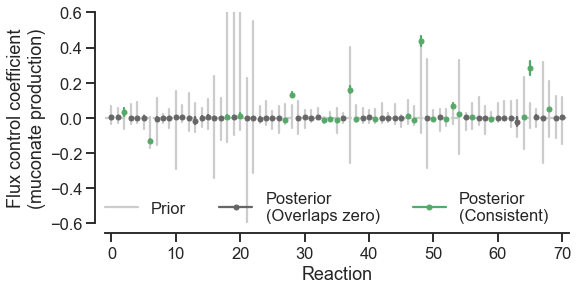

In [19]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

for i, (name, col) in enumerate(fcc.iteritems()):
    
    if name in fcc.columns[fcc_consistent]:
        color='g'
    
        l_g = ax.plot([i, i], pm.hpd(col), color=color)
        dot_g = ax.plot(i, col.median(), '.', color=color, ms=10)

    else:
        color='.4'
    
        l_4 = ax.plot([i, i], pm.hpd(col), color=color)
        dot_4 = ax.plot(i, col.median(), '.', color=color, ms=10)
    
    l_p = ax.plot([i, i], pm.hpd(fcc_prior[name]), color='.8', zorder=0)
    


ax.axhline(0, ls='--', color='.8', zorder=0)

#ax.set_ylim([-5E-5, 1E-4])
# ax.set_xlim([-1, 16])

plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax.set_ylabel('Flux control coefficient\n(muconate production)')

ax.set_xlabel('Reaction')

plt.legend((l_p[0], (l_4[0], dot_4[0]), (l_g[0], dot_g[0]), ),
           ('Prior', 'Posterior\n(Overlaps zero)', 'Posterior\n(Consistent)'),
           borderaxespad=0, borderpad=0, ncol=3)


xs = np.where(fcc_consistent)[0]
ys = fcc.loc[:, fcc_consistent].mean(0).values
labels = fcc.columns[fcc_consistent]

plt.ylim([-.6, .6])
plt.xlim([-1, ll.nr])
plt.tight_layout()

sns.despine(trim=False, offset=10)
# plt.savefig('fcc_figs_quant/fccs_plot.svg', transparent=True)